In [1]:
%run ClusterTree.ipynb
# %run losses.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Convolutional layer 2
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 6)  # Latent space layer
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 32*7*7),  # Fully connected layer
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # Reshape to feature maps
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Deconvolutional layer 1
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Deconvolutional layer 2
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode input into latent space
        latent = self.encoder(x)

        # Decode latent representation
        reconstruction = self.decoder(latent)

        return reconstruction , latent 

# Instantiate the model
model = EncoderDecoder()


In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


trainset.data = trainset.data[:4000]
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

In [4]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_images=640):
        self.dataset = dataset
        self.num_images = num_images

    def __getitem__(self, index):
        
        img, _ = self.dataset[index]  # Get image and ignore label
        return img

    def __len__(self):
        return len(self.dataset)


In [5]:
train_dataset_no_labels = TestDataset(trainset)
train_dataset_no_labels.__len__()
# num_images = 2000
# mnist_subset = torch.utils.data.Subset(train_dataset_no_labels, range(num_images))

4000

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset_no_labels, batch_size=64, shuffle=True)

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Pretraining 
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs , latent = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 8 == 7:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,     8] loss: 0.011
[1,    16] loss: 0.010
[1,    24] loss: 0.009
[1,    32] loss: 0.008
[1,    40] loss: 0.007
[1,    48] loss: 0.007
[1,    56] loss: 0.006
[2,     8] loss: 0.005
[2,    16] loss: 0.005
[2,    24] loss: 0.004
[2,    32] loss: 0.004
[2,    40] loss: 0.003
[2,    48] loss: 0.003
[2,    56] loss: 0.003
[3,     8] loss: 0.003
[3,    16] loss: 0.003
[3,    24] loss: 0.003
[3,    32] loss: 0.003
[3,    40] loss: 0.003
[3,    48] loss: 0.002
[3,    56] loss: 0.003
[4,     8] loss: 0.002
[4,    16] loss: 0.002
[4,    24] loss: 0.002
[4,    32] loss: 0.002
[4,    40] loss: 0.002
[4,    48] loss: 0.002
[4,    56] loss: 0.002
[5,     8] loss: 0.002
[5,    16] loss: 0.002
[5,    24] loss: 0.002
[5,    32] loss: 0.002
[5,    40] loss: 0.002
[5,    48] loss: 0.002
[5,    56] loss: 0.002
Finished Training


In [8]:
# torch.save(model.state_dict(), 'model_weight_pretrained_5000.pth')

In [7]:
model.load_state_dict(torch.load('model_weight_pretrained_4000.pth'))

<All keys matched successfully>

In [8]:
import matplotlib.pyplot as plt

def print_model_output(model, dataloader, index):
    # Get the dataset from the dataloader
    dataset = dataloader.dataset

    # Get the input image from the dataset
    img = dataset.dataset[index][0]  # Access the dataset within the DataLoader
    print(img.shape)
    
    # Pass the image through the model
    with torch.no_grad():
        output , _ = model(img.unsqueeze(0))
        output = output.squeeze(0)

    # Convert torch tensors to numpy arrays
    img = img.numpy()
    output = output.numpy()

    # Plot the original image and the model's output
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output[0], cmap='gray')
    plt.title('Model Output')
    plt.axis('off')

    plt.show()


torch.Size([1, 28, 28])


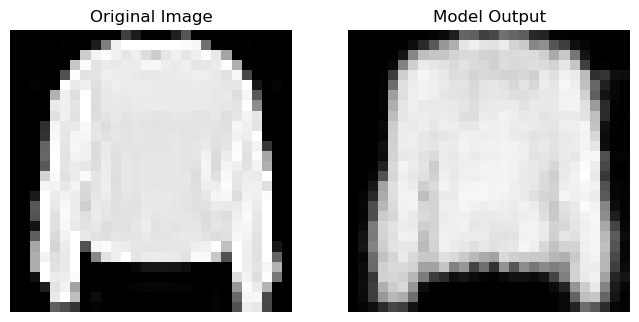

In [30]:
print_model_output(model, train_loader, 7)

In [10]:
#We need to incorporate the rest of the losses and tree formation
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
trainset2 = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


trainset2.data = trainset2.data[2000:3000]
un_train_dataset_no_labels = TestDataset(trainset2)
un_train_loader = torch.utils.data.DataLoader(un_train_dataset_no_labels, batch_size=64, shuffle=True)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2,threshold=0.01)

In [11]:
un_train_loader

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
   
    for i, data in enumerate(un_train_loader, 0):
        
        inputs = data
       
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs , latent = model(inputs)
        
        latent = latent.detach().numpy()
        if i==0:
            clust_tree = ClusterTree(D = latent , L = 10 , T = 1 ,P = 0 )

        else:
            clust_tree.build_tree(latent)
            
            
            
        if i==0:
            continue
        # Compute loss
        mse_loss = criterion(outputs , inputs)

        loss_nc = clust_tree.calculate_loss_NC()

        loss_dc = clust_tree.calculate_loss_DC()

        loss = mse_loss + loss_nc + loss_dc

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 16 == 15:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0
    # if epoch < 4:
    #     scheduler.step()
    scheduler_2.step(loss)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
[1,    16] loss: 1.843953
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
[2,    16] loss: 0.566407
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
[3,    16] loss: 0.373430
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
[4,    16] loss: 0.331879
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 

In [83]:
trainset1 = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


trainset1.data = trainset1.data[4000:5000]
u_train_dataset_no_labels = TestDataset(trainset1)
u_train_loader = torch.utils.data.DataLoader(u_train_dataset_no_labels, batch_size=64, shuffle=True)

In [84]:


# for j in [test_train_loader , test_train_loader_1]:
def test_sim(dataloader , index1 , index2):
    ouput = []
    for i, data in enumerate(dataloader, 0):
    
        dataset = dataloader.dataset
        img1 = dataset.dataset[index1][0]
        img2 = dataset.dataset[index2][0]
    
        _ , point = model(img1.unsqueeze(0))
        _ , point2 = model(img2.unsqueeze(0))
     
        
        
        ouput.append(point.detach().numpy())
        ouput.append(point2.detach().numpy())
    
    return clust_tree.test_data(ouput[0][0] , ouput[1][0])

In [86]:
def print_images(model , dataloader , index1 , index2):

    dataset = dataloader.dataset

    # Get the input image from the dataset
    img1 = dataset.dataset[index1][0]  # Access the dataset within the DataLoader
    
    
    # Pass the image through the model
    
    img2 = dataset.dataset[index2][0] 
    # Convert torch tensors to numpy arrays
    img1 = img1.numpy()
    img2 = img2.numpy()

    # Plot the original image and the model's output
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1[0], cmap='gray')
    plt.title('Image1')
    plt.axis('off')

   

    plt.subplot(1, 2, 2)
    plt.imshow(img2[0], cmap='gray')
    plt.title('Image2')
    plt.axis('off')

    plt.show()

    test_sim(dataloader , index1 , index2)

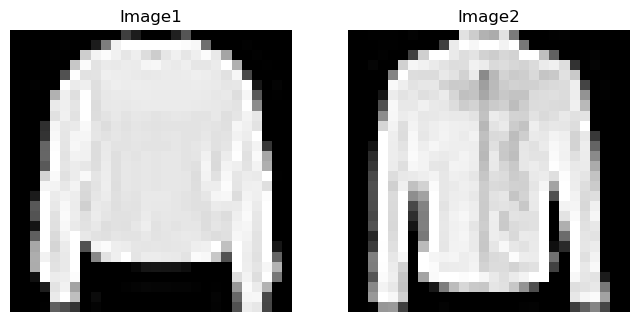

Belongs to the same cluster.


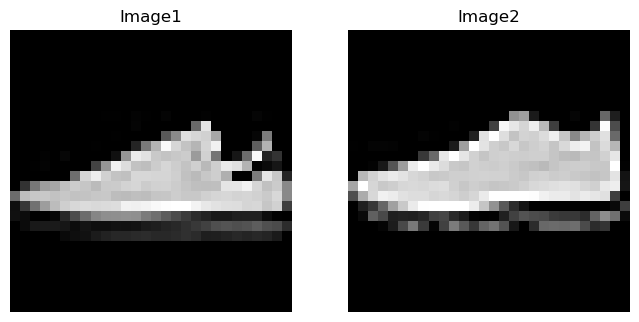

Belongs to the same cluster.


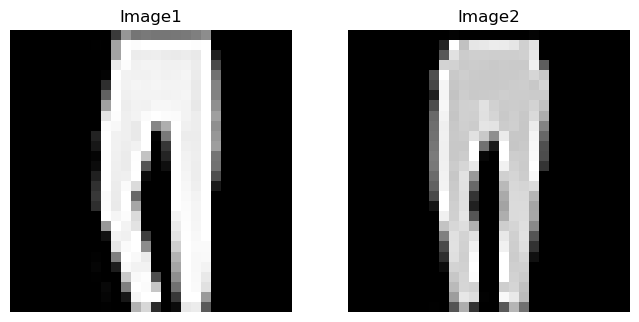

Belongs to the same cluster.


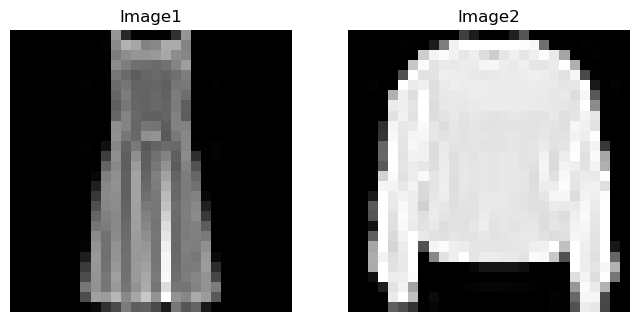

Does not belong to same cluster.


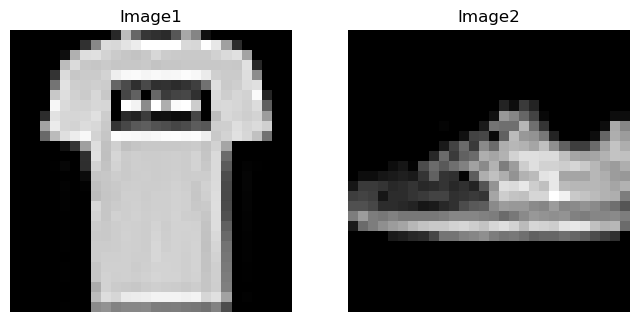

Does not belong to same cluster.


In [87]:
print_images(model, train_loader, 7 , 311
                  )

print_images(model, train_loader, 6 , 310
                  )

print_images(model, u_train_loader, 7 , 115
                  )

print_images(model, train_loader, 31 , 7
                  )

print_images(model, train_loader, 1 , 529
                  )